# Recursive Forecasting: skforecast with future known features
Conda environment: `time-series`   
17 May 2024  

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg

from feature_engine.datetime import DatetimeFeatures

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [3]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("H")
    .agg({"demand": "sum"})
)

df

,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"
...,...
2015-02-28 19:00:00,"9,596.7771"
2015-02-28 20:00:00,"8,883.2303"
2015-02-28 21:00:00,"8,320.2605"


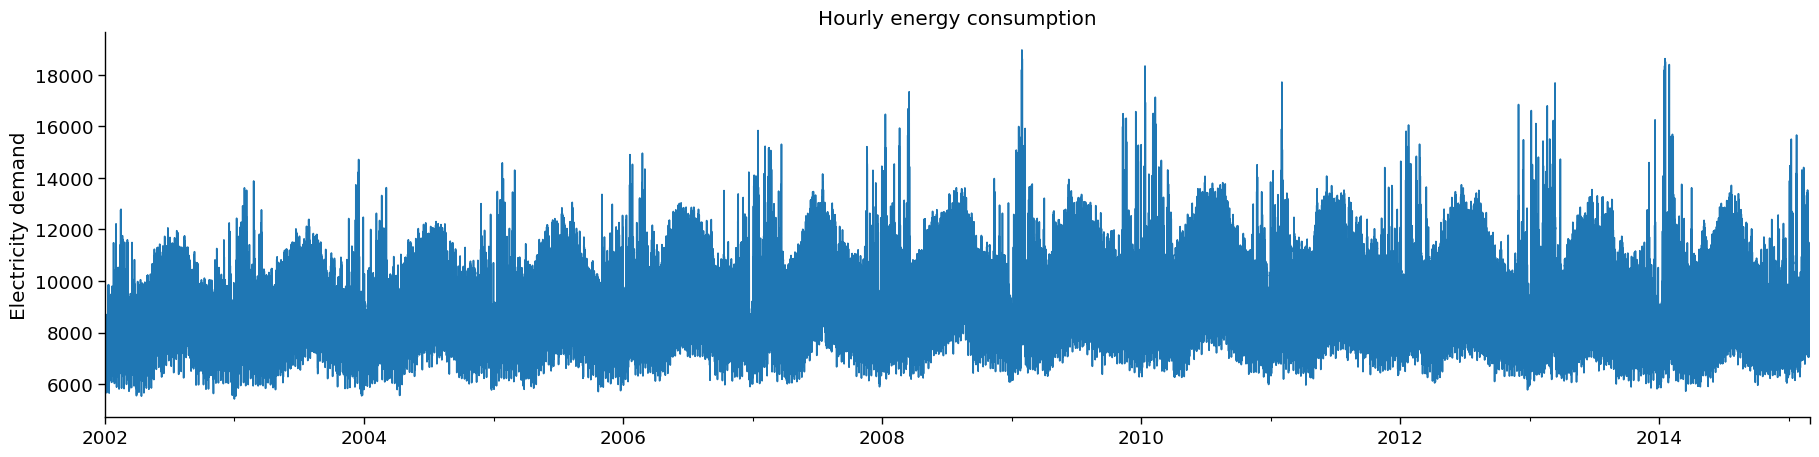

In [4]:
df.plot(legend=None)

plt.title("Hourly energy consumption")
plt.ylabel("Electricity demand")
plt.xlabel("")
plt.show()

## 2) Train/Test split

In [5]:
# Split into train and test

# We leave the last February in the test set
end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

X_train.tail()

,demand
date_time,
2014-12-31 19:00:00,"7,818.4614"
2014-12-31 20:00:00,"7,801.2018"
2014-12-31 21:00:00,"7,516.4730"
2014-12-31 22:00:00,"7,571.3014"
2014-12-31 23:00:00,"8,352.9921"


In [6]:
X_test.head()

,demand
date_time,
2015-01-01 00:00:00,"7,804.0862"
2015-01-01 01:00:00,"7,174.3400"
2015-01-01 02:00:00,"6,654.2834"
2015-01-01 03:00:00,"6,429.5980"
2015-01-01 04:00:00,"6,412.7853"


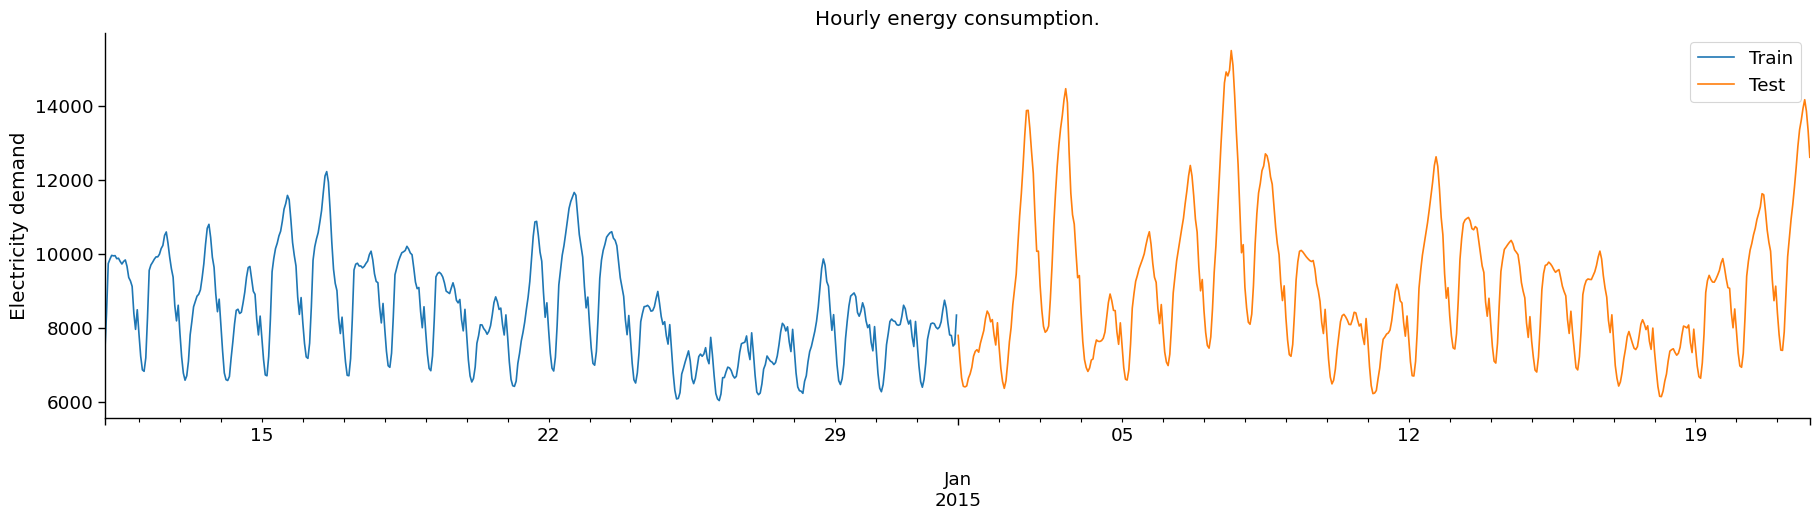

In [7]:
fig, ax = plt.subplots()

X_train.tail(500).plot(ax=ax)
X_test.head(500).plot(ax=ax)

ax.set_title('Hourly energy consumption.')
ax.legend(["Train", "Test"])
ax.set_xlabel("")
ax.set_ylabel("Electricity demand")

plt.show()

## 3) Feature engineering

In [8]:
# Datetime features -> future known features
datime_f = DatetimeFeatures(
    features_to_extract= ["month", "day_of_week", "hour"],
    drop_original=True
)

datime_f

DatetimeFeatures(features_to_extract=['month', 'day_of_week', 'hour'])

In [9]:
# Let's explore what we got
datetime_df_train = pd.DataFrame(
        X_train.index,
        index=X_train.index
)

datime_f.fit_transform(
    datetime_df_train
)

,date_time_month,date_time_day_of_week,date_time_hour
date_time,,,
2002-01-01 00:00:00,1,1,0
2002-01-01 01:00:00,1,1,1
2002-01-01 02:00:00,1,1,2
2002-01-01 03:00:00,1,1,3
2002-01-01 04:00:00,1,1,4
...,...,...,...
2014-12-31 19:00:00,12,2,19
2014-12-31 20:00:00,12,2,20
2014-12-31 21:00:00,12,2,21


In [10]:
lasso_model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("lasso", Lasso(random_state=9, alpha=10))
])

lasso_model

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lasso', Lasso(alpha=10, random_state=9))])

## 4) Recursive Forecast

### 4.1) Train

In [11]:
forecaster = ForecasterAutoreg(
    regressor=lasso_model,
    lags=[1, 24, 6*24],           # the lag features to create
    transformer_exog=datime_f,    # to get the datetime features
    forecaster_id="recursive"
)

forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lasso', Lasso(alpha=10, random_state=9))]) 
Lags: [  1  24 144] 
Transformer for y: None 
Transformer for exog: DatetimeFeatures(features_to_extract=['month', 'day_of_week', 'hour']) 
Window size: 144 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'lasso__alpha': 10, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': 9, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-17 13:30:04 
Last fit date: None 
Skforecast version: 0.11.0 
Python v

In [12]:
forecaster.fit(
    y=X_train["demand"],
    exog=datetime_df_train,
)
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lasso', Lasso(alpha=10, random_state=9))]) 
Lags: [  1  24 144] 
Transformer for y: None 
Transformer for exog: DatetimeFeatures(features_to_extract=['month', 'day_of_week', 'hour']) 
Window size: 144 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['date_time'] 
Training range: [Timestamp('2002-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'lasso__alpha': 10, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': 9, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False}

In [13]:
# Explore the inputs of the forecaster : X and y
X, y = forecaster.create_train_X_y(
    y=X_train["demand"],
    exog=datetime_df_train,
)
X

,lag_1,lag_24,lag_144,date_time_month,date_time_day_of_week,date_time_hour
date_time,,,,,,
2002-01-07 00:00:00,"7,290.2343","6,722.9845","6,919.3661",1,0,0
2002-01-07 01:00:00,"6,808.0089","7,140.5912","7,165.9742",1,0,1
2002-01-07 02:00:00,"7,209.2857","6,562.0221","6,406.5430",1,0,2
2002-01-07 03:00:00,"6,535.8183","5,976.0208","5,815.5378",1,0,3
2002-01-07 04:00:00,"6,112.3826","5,688.4682","5,497.7329",1,0,4
...,...,...,...,...,...,...
2014-12-31 19:00:00,"8,139.2511","8,110.9378","7,301.8554",12,2,19
2014-12-31 20:00:00,"7,818.4614","8,214.0386","7,472.7798",12,2,20
2014-12-31 21:00:00,"7,801.2018","7,768.0877","7,170.4729",12,2,21


In [14]:
X_train.loc[:"2002-01-07 00:00:00"].tail(2)

,demand
date_time,
2002-01-06 23:00:00,"7,290.2343"
2002-01-07 00:00:00,"6,808.0089"


### 4.2) Predict
We are going to forecast the next `24h`.

In [16]:
HORIZON = 24

datetime_df_test = pd.DataFrame(
        X_test.head(HORIZON).index,
        index=X_test.head(HORIZON).index
)
datetime_df_test

,date_time
date_time,
2015-01-01 00:00:00,2015-01-01 00:00:00
2015-01-01 01:00:00,2015-01-01 01:00:00
2015-01-01 02:00:00,2015-01-01 02:00:00
2015-01-01 03:00:00,2015-01-01 03:00:00
2015-01-01 04:00:00,2015-01-01 04:00:00
2015-01-01 05:00:00,2015-01-01 05:00:00
2015-01-01 06:00:00,2015-01-01 06:00:00
2015-01-01 07:00:00,2015-01-01 07:00:00
2015-01-01 08:00:00,2015-01-01 08:00:00


In [17]:
predictions = forecaster.predict(
    steps=HORIZON,
    exog=datetime_df_test,
)

predictions

2015-01-01 00:00:00   8,157.5313
2015-01-01 01:00:00   7,868.4164
2015-01-01 02:00:00   7,550.1278
2015-01-01 03:00:00   7,290.6024
2015-01-01 04:00:00   7,146.9305
2015-01-01 05:00:00   7,143.8442
2015-01-01 06:00:00   7,296.2766
2015-01-01 07:00:00   7,443.2763
2015-01-01 08:00:00   7,593.3634
2015-01-01 09:00:00   7,711.0069
2015-01-01 10:00:00   7,786.6961
2015-01-01 11:00:00   7,815.1364
2015-01-01 12:00:00   7,815.1460
2015-01-01 13:00:00   7,817.6658
2015-01-01 14:00:00   7,849.2157
2015-01-01 15:00:00   7,953.4082
2015-01-01 16:00:00   8,105.4383
2015-01-01 17:00:00   8,192.0435
2015-01-01 18:00:00   8,179.2858
2015-01-01 19:00:00   8,113.7083
2015-01-01 20:00:00   8,080.1010
2015-01-01 21:00:00   7,970.0676
2015-01-01 22:00:00   7,884.1618
2015-01-01 23:00:00   8,030.2635
Freq: H, Name: pred, dtype: float64

### 4.3) Measure Forecast accuracy

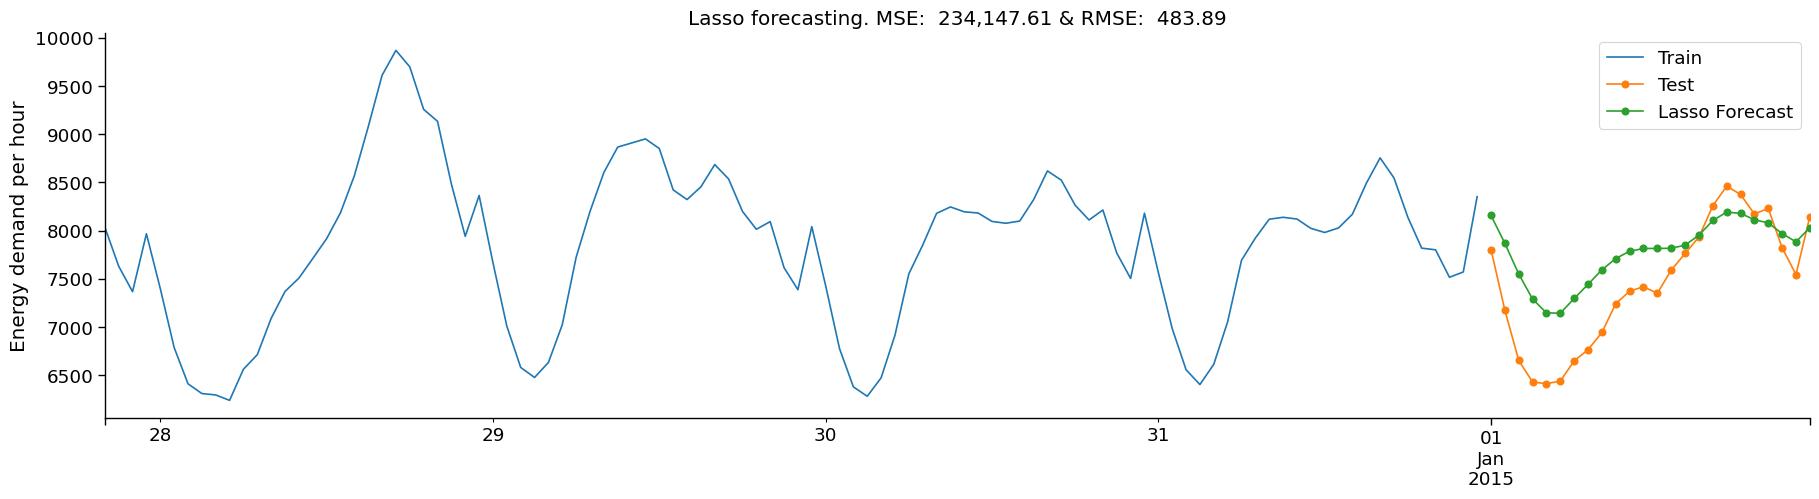

In [22]:
# MSE
error_mse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index] , 
                y_pred = predictions,
                squared=True,
            )
# RMSE 
error_rmse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index], 
                y_pred = predictions,
                squared=False,
            )

fig, ax = plt.subplots()

X_train.tail(100).plot(ax=ax)
X_test.head(24).plot(ax=ax, marker="o")
predictions.plot(ax=ax, marker="o")

ax.legend(["Train", "Test", "Lasso Forecast"])
plt.title(f"Lasso forecasting. MSE: {error_mse: ,.2f} & RMSE: {error_rmse: ,.2f}")
plt.ylabel("Energy demand per hour")
plt.xlabel("")

plt.show()

## 5) Predict any time point in the future
Say we want to predict energy demand later in the future with the model we just trained. First, we need to gather the data necessary to create the lags (144 data points).    
Then, pass that past data to the forecaster.

In [24]:
forecaster.window_size

144

In [27]:
# Say we want to predict energy demand for 1st of February
forecast_start = '2015-02-01 00:00:00'

past_data_available = X_test[:'2015-01-31 23:59:59'].tail(forecaster.window_size)
past_data_available

,demand
date_time,
2015-01-26 00:00:00,"7,492.9846"
2015-01-26 01:00:00,"6,991.4994"
2015-01-26 02:00:00,"6,595.5844"
2015-01-26 03:00:00,"6,469.6956"
2015-01-26 04:00:00,"6,597.0293"
...,...
2015-01-31 19:00:00,"8,441.9289"
2015-01-31 20:00:00,"8,391.3746"
2015-01-31 21:00:00,"7,949.1561"


In [33]:
horizon = X_test['2015-01-31 23:59:59':].head(24)

datetime_df_test = pd.DataFrame(
    horizon.index,
    index=horizon.index,
)

predictions = forecaster.predict(
    steps=HORIZON,
    last_window=past_data_available["demand"],
    exog=datetime_df_test,
)

pd.DataFrame(predictions).reset_index()

,index,pred
0,2015-02-01 00:00:00,"8,047.8582"
1,2015-02-01 01:00:00,"7,675.6549"
2,2015-02-01 02:00:00,"7,299.0624"
3,2015-02-01 03:00:00,"7,004.6560"
4,2015-02-01 04:00:00,"6,838.6120"
5,2015-02-01 05:00:00,"6,816.5429"
6,2015-02-01 06:00:00,"6,925.8130"
7,2015-02-01 07:00:00,"7,076.3349"
8,2015-02-01 08:00:00,"7,271.7506"
9,2015-02-01 09:00:00,"7,438.8136"


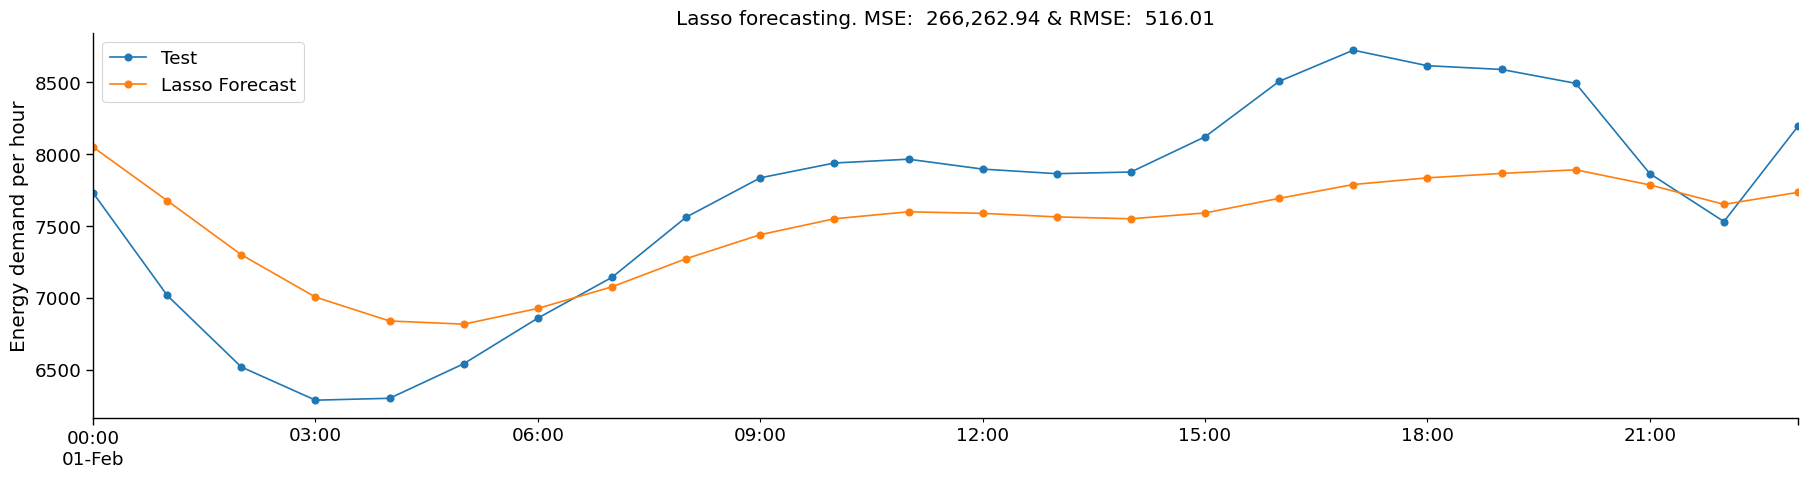

In [34]:
# MSE
error_mse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index] , 
                y_pred = predictions,
                squared=True,
            )
# RMSE 
error_rmse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index], 
                y_pred = predictions,
                squared=False,
            )

fig, ax = plt.subplots()

X_test["2015-01-31 23:59:59":].head(HORIZON).plot(ax=ax, marker="o")
predictions.plot(ax=ax, marker="o")

ax.legend(["Test", "Lasso Forecast"])
plt.title(f"Lasso forecasting. MSE: {error_mse: ,.2f} & RMSE: {error_rmse: ,.2f}")
plt.ylabel("Energy demand per hour")
plt.xlabel("")

plt.show()

## 6) Feature importance

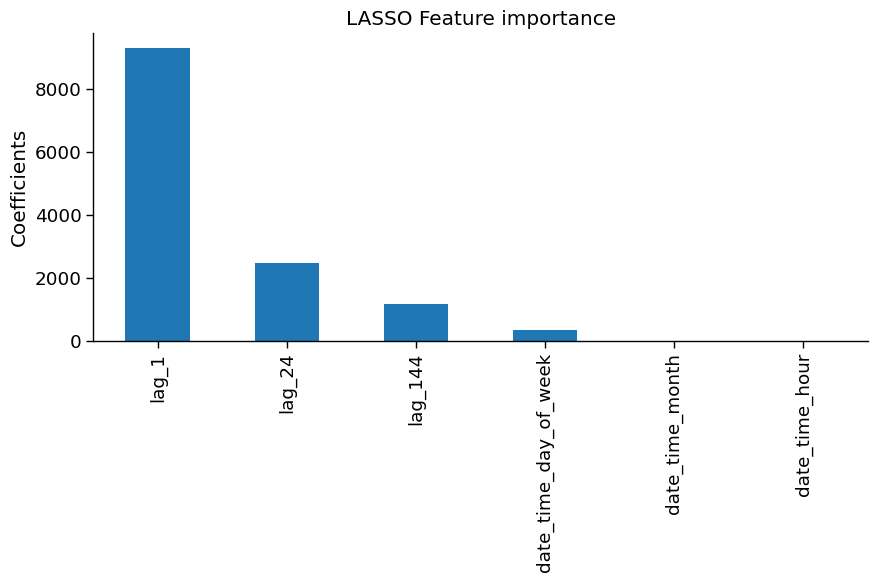

In [56]:
pd.Series(
    forecaster.regressor.named_steps["lasso"].coef_,
    index= forecaster.regressor.feature_names_in_
).abs().sort_values(ascending=False).plot(kind="bar", figsize=(10,4))

plt.title("LASSO Feature importance")
plt.ylabel("Coefficients")
plt.show()